## Time-derived perfomance metrics calculation (Utilization and Throughput)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy
import csv
from tabulate import tabulate

def derived_metrics_calc(num_denum_df, obj, num_denum_dict):
    num_denum_df.drop(columns=['stat'], inplace=True)
    metric_list = []
    for key in num_denum_dict.keys():
        value = num_denum_dict[key][0]
        metric = num_denum_dict[key][1]

        num_df = num_denum_df[num_denum_df['metric'] == key]
        denum_df = num_denum_df[num_denum_df['metric'] == value]

        num_df = num_df.rename(columns={'value': key})
        denum_df = denum_df.rename(columns={'value': value})

        num_df = num_df.drop(columns=['metric'])
        denum_df = denum_df.drop(columns=['metric'])

        metric_df = pd.merge(num_df, denum_df, on=['lambda', 'iteration'], how='inner', validate='many_to_one')
        metric_df.rename(columns={'node_x': 'node'}, inplace=True)
        metric_df.drop(columns=['node_y'], inplace=True)
        metric_df[metric] = metric_df[key] / metric_df[value]

        metric_df = metric_df[['iteration','lambda','node',key,value,metric]]
        metric_df.to_csv(os.path.join('output',f'{obj}_rho.csv'), index=False)
        metric_df = metric_df.rename(columns={metric: 'value'})
        metric_df['metric'] = metric
        curr_list = []
        for node in metric_df['node'].unique():
            node_df = metric_df[metric_df['node'] == node]
            curr_list.append(node_df)
        metric_list.append(curr_list)
    return metric_list

## Preprocessing


All csv files containing run statistics are read and a single dataframe is created with the concatenated csvs by adding a 'lambda' column with the arrival rate values. Three other columns are extracted from the 'statistic' column: 'node' containing the reference node of the statistic or system if it is global, 'metric' indicating the measured metric and finally 'stat' specifying whether the measured value is mean, minimum, maximum or standard deviation.

Finally, a list of dataframes is created one for each metric and node taking only the mean as the statistic.

In [2]:
output_path = os.path.join(".", "output")
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Function to remove outliers based on Z-score
def remove_outliers_zscore(df, column, threshold=3):
    z_scores = np.abs((df[column] - df[column].mean()) / df[column].std())
    return df[z_scores <= threshold]

def preprocessing(path, obj):
    filenames = os.listdir(path)
    stats_df_list = []
    for i in filenames:
        lambda_val = i.split('=')[1].split('_')[0]
        stats_path = os.path.join(path, i)
        stats_df = pd.read_csv(stats_path)
        stats_df['lambda'] = lambda_val
        stats_df_list.append(stats_df)
    stats_df = pd.concat(stats_df_list)

    stats_df['node'] = stats_df['statistic'].apply(lambda x: x.split('-')[0])
    stats_df['metric'] = stats_df['statistic'].apply(lambda x: x.split('-')[1])
    stats_df['stat'] = stats_df['statistic'].apply(lambda x: x.split('-')[2])
    stats_df.drop(columns=['statistic'], inplace=True)

    stats_df = stats_df[stats_df['stat'].isin(['avg', 'val'])]
    
    # List of one DataFrame for each metric selecting only the average as statistic
    metrics = stats_df['metric'].unique()
    metrics_avg_df_list = []
    metrics = metrics[metrics != 'interarrival']
    metrics = metrics[metrics != 'service']
    metrics = metrics[metrics != 'observation_time']
    metrics = metrics[metrics != 'completions']
    metrics = metrics[metrics != 'busytime']
    
    for i in metrics:
        metrics_avg_df = stats_df[stats_df['metric'] == i]
        
        # Remove outliers for the 'value' column (or other numerical columns)
        #if 'value' in metrics_avg_df.columns:
           # metrics_avg_df = remove_outliers_zscore(metrics_avg_df, 'value')
        
        metrics_avg_df_list.append(metrics_avg_df)

    metrics_nodes_avg_df_list = []
    for i in metrics_avg_df_list:
        nodes = i['node'].unique()
        node_avg_df_list = []
        for j in nodes:
            node_avg_df = i[i['node'] == j]
            node_avg_df_list.append(node_avg_df)
        metrics_nodes_avg_df_list.append(node_avg_df_list)
    metric_dict = {'busytime':['observation_time', 'utilization'], 'completions':['observation_time', 'throughput']}
    derived_metrics = derived_metrics_calc(stats_df, obj, metric_dict)
    for i in derived_metrics:
        metrics_nodes_avg_df_list.append(i)
        
    return metrics_nodes_avg_df_list


## Boxplot funcion
Boxplots of the average of population number, throughput and response time with arrival rate in a range 0.5, 1.2 job/sec

In [3]:
def boxplot(metrics_nodes_avg_df_list):    
    for metric in metrics_nodes_avg_df_list:
        figure, axis = plt.subplots(2, 2, figsize=(15, 10))
        for i, boxplot_df in enumerate(metric):
            
            boxplot_df['value'].astype(float)
            boxplot_df['lambda'].astype(float)
            boxplot_df = boxplot_df.sort_values(by='lambda')

            curr_metric = boxplot_df['metric'].unique()[0]
            curr_node = boxplot_df['node'].unique()[0]
            x = i // 2
            y = i % 2

            boxplot_df.boxplot(column='value', by='lambda', ax = axis[x, y], showfliers=False)
            plt.suptitle('')
            axis[x, y].set_title(f'Boxplot of {curr_metric} of the {curr_node} node')

        plt.tight_layout()
        plt.show()

## Confidence interval calculation
Confidence intervals are calculated on the batches of runs made as the lambda parameter changes.

The following formula is used to calculate the interval:

$
CI = \bar{x} \pm z \cdot \frac{\sigma}{\sqrt{n}}
$

Where:
- $\bar{x}$ is the sample mean.
- $z$ is the critical value of the standard normal distribution corresponding to the chosen confidence level (e.g., 1.96 for 95%).
- $\sigma$ is the population standard deviation.
- $n$ is the sample size.

In [4]:
def confidence_interval(metrics_nodes_avg_df_list, critical_value, obj):
    ci_df = []
    for metric in metrics_nodes_avg_df_list:
        metric_list = []
        for node_df in metric:
            curr_metric = node_df['metric'].unique()[0]
            curr_node = node_df['node'].unique()[0]
            
            df = node_df.groupby(["lambda"])['value'].describe()[["count", "mean", "std"]].reset_index()
            df["lower_ci"] = df["mean"] - critical_value*(df["std"]/np.sqrt(df["count"]))
            df["upper_ci"] = df["mean"] + critical_value*(df["std"]/np.sqrt(df["count"]))

            df.to_csv(os.path.join("output", f"{obj}_conf_int_{curr_node}_{curr_metric}.csv"), index=False)
            df['metric'] = curr_metric
            df['node'] = curr_node
            metric_list.append(df)
        ci_df.append(metric_list)
    return ci_df

In [5]:
def plot_confidence_interval(ci_df, analitycal_perf):
    colors = {'A': ['crimson', 'darkred'], 'B': ['darkblue', 'royalblue'], 'P': ['darkgreen', 'limegreen']}
    # Define markers for each key
    markers = {
        "analytical": 'o',  # Circle
        "simulation": 's',  # Square
    }
    markers_throughput = {
        "A": 'o',  # Circle
        "B": 's',  # Square
        "P": 'D',  # Diamond
    }
    for metric in ci_df:
        fig, axis = plt.subplots(2, 2, figsize=(15, 10))
        for i, df in enumerate(metric):
            x = i // 2
            y = i % 2

            curr_metric = df['metric'].unique()[0]
            curr_node = df['node'].unique()[0]

            if curr_metric != "utilization" or curr_node != "SYSTEM":
                analitycal_df = analitycal_perf[curr_metric][curr_node]
            else:
                analitycal_df = None
                
            # error bar plot with mean point
            up = df['upper_ci'] - df['mean']
            low = df['mean'] - df['lower_ci']
            df['lambda'] = df['lambda'].astype(float)

            axis[x, y].errorbar(df['lambda'], df['mean'], yerr=[low, up], fmt=markers["simulation"], capsize=5, label='Confidence interval 95%')

            # lineplot of the mean points
            axis[x, y].plot(df['lambda'], df['mean'], linestyle='-', marker=markers['simulation'], color='b', label='simulation run')
            if analitycal_df is not None:
                axis[x, y].plot(analitycal_df['lambda'], analitycal_df['value'], linestyle='-', marker=markers['analytical'], color='r', label='analitycal model')

            axis[x, y].set_xlabel('Lambda')
            axis[x, y].set_ylabel(f"Avg {curr_metric} in {curr_node}")
            axis[x, y].set_title(f"Confidence interval for {curr_node} average {curr_metric}")
            axis[x, y].legend()
        plt.tight_layout()
        plt.show()

        if 'throughput' in df['metric'].values:
            fig, ax = plt.subplots(figsize=(10, 6))

            for df in metric:
                node = df['node'].unique()[0]
                if node == 'SYSTEM':
                    continue
                base_color = colors[df['node'].unique()[0]][0]
                darker_color = colors[df['node'].unique()[0]][1]
                ax.errorbar(df['lambda'], df['mean'], 
                            yerr=[df['mean'] - df['lower_ci'], df['upper_ci'] - df['mean']], 
                            fmt=markers_throughput[node], capsize=5, color = darker_color)

                ax.plot(df['lambda'], df['mean'], linestyle='-', marker=markers_throughput[node], label=f'Throughput of {df["node"].unique()[0]}', color = base_color)

            # Aggiunta delle etichette e del titolo
            ax.set_xlabel('Lambda')
            ax.set_ylabel('Avg')
            ax.set_title('Throughput comparison')
            ax.legend()
            # Mostra il grafico
            plt.show()


## Simulation vs. Analitycal model

In [6]:
def analitycal_preprocessing(obj):
    metric_node_analitycal_dict = {}
    servers = ['[A]', '[B]', '[P]', '[S]']
    metrics = {'E[T]': 'response_time', 'E[N]': 'population', 'X': 'throughput', 'rho': 'utilization'} 

    local_perf = pd.read_csv(os.path.join('output', f'{obj}_analitycal_local_performances.csv'))
    global_perf = pd.read_csv(os.path.join('output', f'{obj}_analitycal_global_performances.csv'))
    rho_perf = pd.read_csv(os.path.join('output', f'{obj}_analitycal_rho.csv'))
    analitycal_perf = pd.merge(local_perf, global_perf, on=['gamma'], how='inner', validate='one_to_one')
    analitycal_perf = pd.merge(analitycal_perf, rho_perf, on=['gamma'], how='inner', validate='one_to_one')
    
    for m in metrics.keys():
        metric_columns = [col for col in analitycal_perf.columns if col.startswith(m)]
        metric_df = analitycal_perf[metric_columns].copy()
        metric_df['metric'] = metrics[m]
        node_dict = {}
        for s in servers:
            s_column = [col for col in metric_df.columns if col.endswith(s)]
            if not s_column:
                continue
            s_df = metric_df[s_column].copy()

            s_df = s_df.rename(columns={s_column[0]: 'value'})
            node = s.split('[')[1].split(']')[0]
            node = 'SYSTEM' if node == 'S' else node
            s_df['node'] = node
            s_df['lambda'] = analitycal_perf['gamma'].copy().astype(float)
            s_df['metric'] = metric_df['metric'].unique()[0]
            node_dict[node] = s_df
        metric_node_analitycal_dict[metrics[m]] = node_dict

    return metric_node_analitycal_dict


def average_stats(stats_df, analitycal_perf):
    avg_metric_list = []
    for metric in stats_df:
        average_list_node = []
        for node in metric:
            node_name = node['node'].unique()[0]
            metric_name = node['metric'].unique()[0]
            if metric_name != 'utilization' or node_name != 'SYSTEM':
                node.drop(columns=['iteration'], inplace=True)
                node = node.groupby(['lambda', 'metric', 'node'])['value'].mean().reset_index()
                node['lambda'] = node['lambda'].astype(float)
                merging_df = analitycal_perf[node['metric'].unique()[0]][node['node'].unique()[0]]
                
                node = pd.merge(node, merging_df, on=['lambda', 'metric', 'node'], how='inner', validate='one_to_one')
                node['diff'] = abs(node['value_x'] - node['value_y'])
                node.rename(columns={'value_x': 'simulation_value', 'value_y': 'analitycal_value'}, inplace=True)
                average_list_node.append(node)
        avg_metric_list.append(average_list_node)
    return avg_metric_list

## Objective 1

Implementation of a model to execute the web app workflow to measure response time (R), population number (N) and throughput (X) quantities

In [ ]:
path = os.path.join("..", "..", "src", "caballo", "domestico", "wwsimulator", "statistics", "objective_1", 'BatchMeansSimulation')
critical_value = scipy.stats.norm.ppf(1-.05/2)
obj = 'obj1'

metrics_nodes_avg_df_list = preprocessing(path, obj)
analitycal_perf = analitycal_preprocessing(obj)

boxplot(metrics_nodes_avg_df_list)
ci_df = confidence_interval(metrics_nodes_avg_df_list, critical_value, obj)
plot_confidence_interval(ci_df, analitycal_perf)

avg_metrics_list = average_stats(metrics_nodes_avg_df_list, analitycal_perf)
for metric in avg_metrics_list:
    for node in metric:
        df = node.reset_index()
        df.drop(columns=['index'], inplace=True)
        display(tabulate(df, headers='keys', tablefmt='html', showindex=False))

## Objective 1 - Transient state

In [ ]:
path = os.path.join("..", "..", "src", "caballo", "domestico", "wwsimulator", "statistics", "objective_1", 'ReplicatedSimulation')
critical_value = scipy.stats.norm.ppf(1-.05/2)
obj = 'obj1'

metrics_nodes_avg_df_list = preprocessing(path, obj)
analitycal_perf = analitycal_preprocessing(obj)

boxplot(metrics_nodes_avg_df_list)
#ci_df = confidence_interval(metrics_nodes_avg_df_list, critical_value, obj)
#plot_confidence_interval(ci_df, analitycal_perf)

avg_metrics_list = average_stats(metrics_nodes_avg_df_list, analitycal_perf)
for metric in avg_metrics_list:
    for node in metric:
        df = node.reset_index()
        df.drop(columns=['index'], inplace=True)
        display(tabulate(df, headers='keys', tablefmt='html', showindex=False))

## Objective 2

The model adds the functionality of two-factor authentication, observe the three metrics variation.

In [ ]:
path = os.path.join("..", "..", "src", "caballo", "domestico", "wwsimulator", "statistics", "objective_2", 'BatchMeansSimulation')
critical_value = scipy.stats.norm.ppf(1-.05/2)
obj = 'obj2'

metrics_nodes_avg_df_list = preprocessing(path, obj)
analitycal_perf = analitycal_preprocessing(obj)

boxplot(metrics_nodes_avg_df_list)

ci_df = confidence_interval(metrics_nodes_avg_df_list, critical_value, obj)
plot_confidence_interval(ci_df, analitycal_perf)

avg_metrics_list = average_stats(metrics_nodes_avg_df_list, analitycal_perf)
for metric in avg_metrics_list:
    for node in metric:
        df = node.reset_index()
        df.drop(columns=['index'], inplace=True)
        display(tabulate(df, headers='keys', tablefmt='html', showindex=False))

## Objective 3

Measure the metrics with an increased workload from 4200 req/h to 5000 req/h

In [ ]:
path = os.path.join("..", "..", "src", "caballo", "domestico", "wwsimulator", "statistics", "objective_3", 'BatchMeansSimulation')
critical_value = scipy.stats.norm.ppf(1-.05/2)
obj = 'obj3'

metrics_nodes_avg_df_list = preprocessing(path, obj)
analitycal_perf = analitycal_preprocessing(obj)

boxplot(metrics_nodes_avg_df_list)

ci_df = confidence_interval(metrics_nodes_avg_df_list, critical_value, obj)
plot_confidence_interval(ci_df, analitycal_perf)

avg_metrics_list = average_stats(metrics_nodes_avg_df_list, analitycal_perf)
for metric in avg_metrics_list:
    for node in metric:
        df = node.reset_index()
        df.drop(columns=['index'], inplace=True)
        display(tabulate(df, headers='keys', tablefmt='html', showindex=False))

## Objective 4

In [11]:
workload = [rate / 100.0 for rate in range(50, 145, 5)]

def plot_average_service_confidence_interval(average_services, plot_metric):
    colors = {
        0.8: ['orangered', 'firebrick'],
        0.75: ['tomato', 'brown'],
        0.7: ['crimson', 'darkred'],
        0.65: ['mediumvioletred', 'maroon'],
        0.6: ['royalblue', 'darkblue'],
        0.55: ['dodgerblue', 'midnightblue'],
        0.5: ['limegreen', 'darkgreen'],
        0.45: ['mediumseagreen', 'seagreen'],
        0.4: ['blueviolet', 'indigo']
    }
    # Define markers for each key
    markers = {
        0.8: 'o',  # Circle
        0.75: 's',  # Square
        0.7: '^',  # Triangle up
        0.65: 'D',  # Diamond
        0.6: 'v',  # Triangle down
        0.55: '<',  # Triangle left
        0.5: '>',  # Triangle right
        0.45: 'p',  # Pentagon
        0.4: '*',  # Star
    }
    plt.figure(figsize=(15, 10))
    for average_service in average_services:
        for metric in average_services[average_service]['ci']:
            if metric[0]['metric'].unique()[0] not in [plot_metric]:
                continue
            for df in metric:
                if df['node'].unique()[0] != 'B':
                    continue
                # if(plot_metric == 'utilization'):
                #     analitycal_df = average_service[average_service]['analitycal'][plot_metric]['B']
                #     plt.plot(analitycal_df['lambda'], analitycal_df['value'], linestyle='-', color=colors[average_service][1], marker='o', label='analitycal: avg service for B = ' + str(average_service))
                # error bar plot with mean point
                up = df['upper_ci'] - df['mean']
                low = df['mean'] - df['lower_ci']
                df['lambda'] = df['lambda'].astype(float)
                plt.errorbar(df['lambda'], df['mean'], yerr=[low, up], fmt=markers[average_service], color=colors[average_service][0], capsize=5)

                # lineplot of the mean points
                plt.plot(df['lambda'], df['mean'], linestyle='-', color=colors[average_service][0], marker=markers[average_service], label=f'simulation: avg service for B = {str(average_service)}')
                plt.xlabel('Lambda')
                plt.ylabel(f"Avg {plot_metric} in B")
                plt.title(f"Confidence interval for B average {plot_metric}")
                plt.legend()
    

    if plot_metric == "utilization":
        plt.axhline(y=1, color='r', linestyle='--', label='max rho')
    if plot_metric == "throughput":
        # Expected heavy workload
        for rate in workload:
            plt.axhline(y=1.4, color='r', linestyle='--')
            plt.axvline(x=1.4, color='r', linestyle='--')
    plt.show()
    


In [ ]:
average_services = [service / 100 for service in range(40, 76, 5)]

average_service_dict = {}
for average_service in average_services:
    preproc_dict = {}
    average_service_str = str(average_service).replace('.', '')
    path = os.path.join("..", "..", "src", "caballo", "domestico", "wwsimulator", "statistics", f"objective_4_{average_service_str}", 'BatchMeansSimulation')
    critical_value = scipy.stats.norm.ppf(1-.05/2)
    obj = f'obj4_{average_service_str}'

    metrics_nodes_avg_df_list = preprocessing(path, obj)
    # analitycal_perf = analitycal_preprocessing(obj)
    ci_df = confidence_interval(metrics_nodes_avg_df_list, critical_value, obj)

    preproc_dict['simulation'] = metrics_nodes_avg_df_list
    # preproc_dict['analitycal'] = analitycal_perf
    preproc_dict['ci'] = ci_df
    average_service_dict[average_service] = preproc_dict

plot_average_service_confidence_interval(average_service_dict, 'utilization')
plot_average_service_confidence_interval(average_service_dict, 'throughput')

In [ ]:
path = os.path.join("..", "..", "src", "caballo", "domestico", "wwsimulator", "statistics", "objective_4_065", 'BatchMeansSimulation')
critical_value = scipy.stats.norm.ppf(1-.05/2)
obj = 'obj4_065'

metrics_nodes_avg_df_list = preprocessing(path, obj)
analitycal_perf = analitycal_preprocessing(obj)

boxplot(metrics_nodes_avg_df_list)
ci_df = confidence_interval(metrics_nodes_avg_df_list, critical_value, obj)
plot_confidence_interval(ci_df, analitycal_perf)

avg_metrics_list = average_stats(metrics_nodes_avg_df_list, analitycal_perf)
for metric in avg_metrics_list:
    for node in metric:
        df = node.reset_index()
        df.drop(columns=['index'], inplace=True)
        display(tabulate(df, headers='keys', tablefmt='html', showindex=False))

In [ ]:
path = os.path.join("..", "..", "src", "caballo", "domestico", "wwsimulator", "statistics", "objective_4_04", 'BatchMeansSimulation')
critical_value = scipy.stats.norm.ppf(1-.05/2)
obj = 'obj4_04'

metrics_nodes_avg_df_list = preprocessing(path, obj)
analitycal_perf = analitycal_preprocessing(obj)

boxplot(metrics_nodes_avg_df_list)
ci_df = confidence_interval(metrics_nodes_avg_df_list, critical_value, obj)
plot_confidence_interval(ci_df, analitycal_perf)

avg_metrics_list = average_stats(metrics_nodes_avg_df_list, analitycal_perf)
for metric in avg_metrics_list:
    for node in metric:
        df = node.reset_index()
        df.drop(columns=['index'], inplace=True)
        display(tabulate(df, headers='keys', tablefmt='html', showindex=False))

## Transient study

In [ ]:
# leggere il file csv in statistics B_improvements
transient_df = pd.read_csv(os.path.join('..', '..', 'src', 'caballo', 'domestico', 'wwsimulator', 'statistics', 'Merged.csv'))
nodes = transient_df['node'].unique()
seeds = transient_df['seed'].unique()
objectives = transient_df['objective'].unique()
colors = ['b', 'g', 'r', 'c', 'm']
markers = ['o', 's', 'D', 'v', 'p']
for objective in objectives:
    print(f'Objective = {objective}')
    for node in nodes:
        i = 0
        plt.figure(figsize=(15, 10))
        plt.xlabel('Time')
        plt.ylabel('Response time')
        for seed in seeds:
            node_df = transient_df[(transient_df['node'] == node) & (transient_df['seed'] == seed) & (transient_df['objective'] == objective)]
            plt.plot(node_df['time'], node_df['value'], linestyle='-', marker=markers[i], color=colors[i], label=f'seed = {seed}')
            plt.title(f'Response time of transient state: {node}')
            plt.xticks(range(0, 70, 5))
            i += 1
        plt.legend()
        plt.show()


Objective = objective_1_TransientSimulation


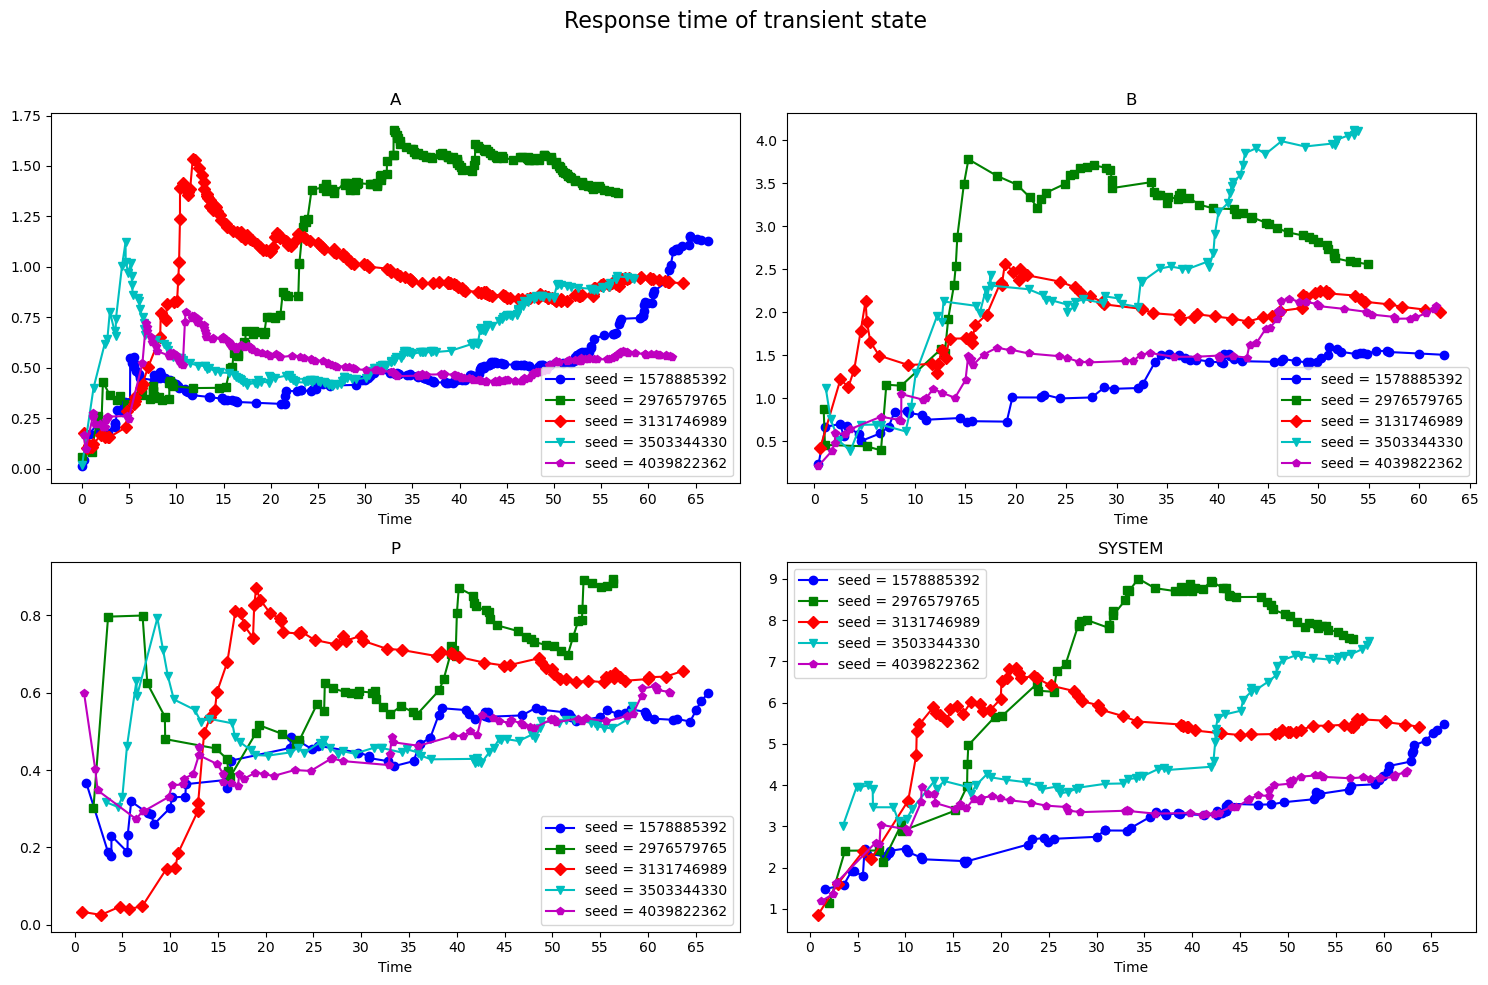

Objective = objective_2_TransientSimulation


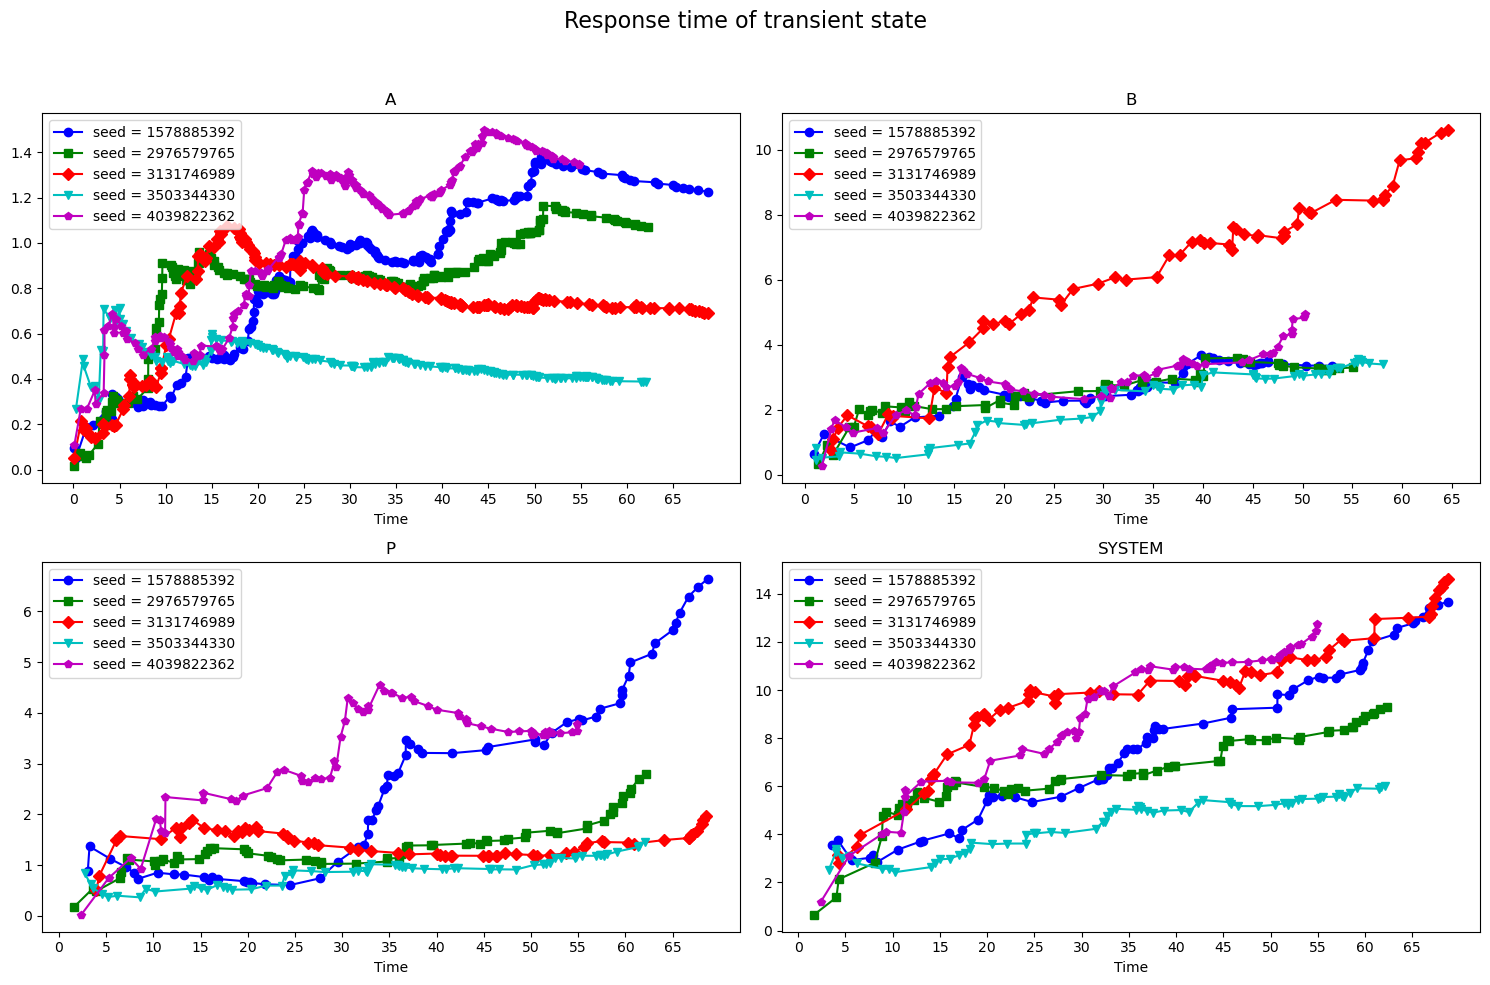

Objective = objective_3_TransientSimulation


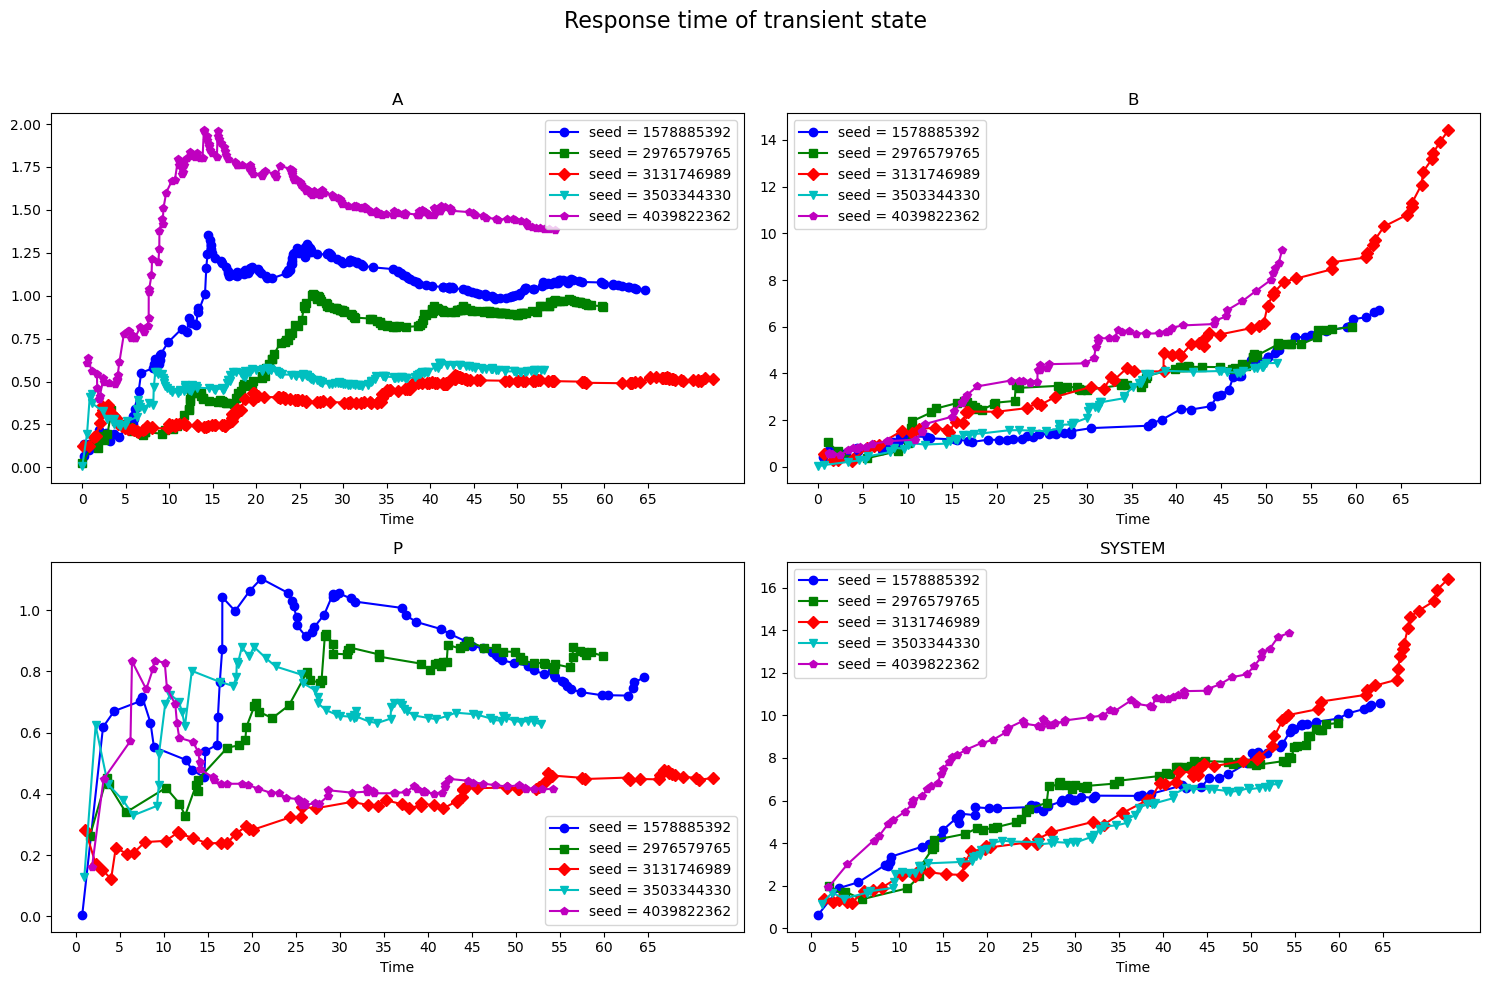

Objective = objective_4_04_TransientSimulation


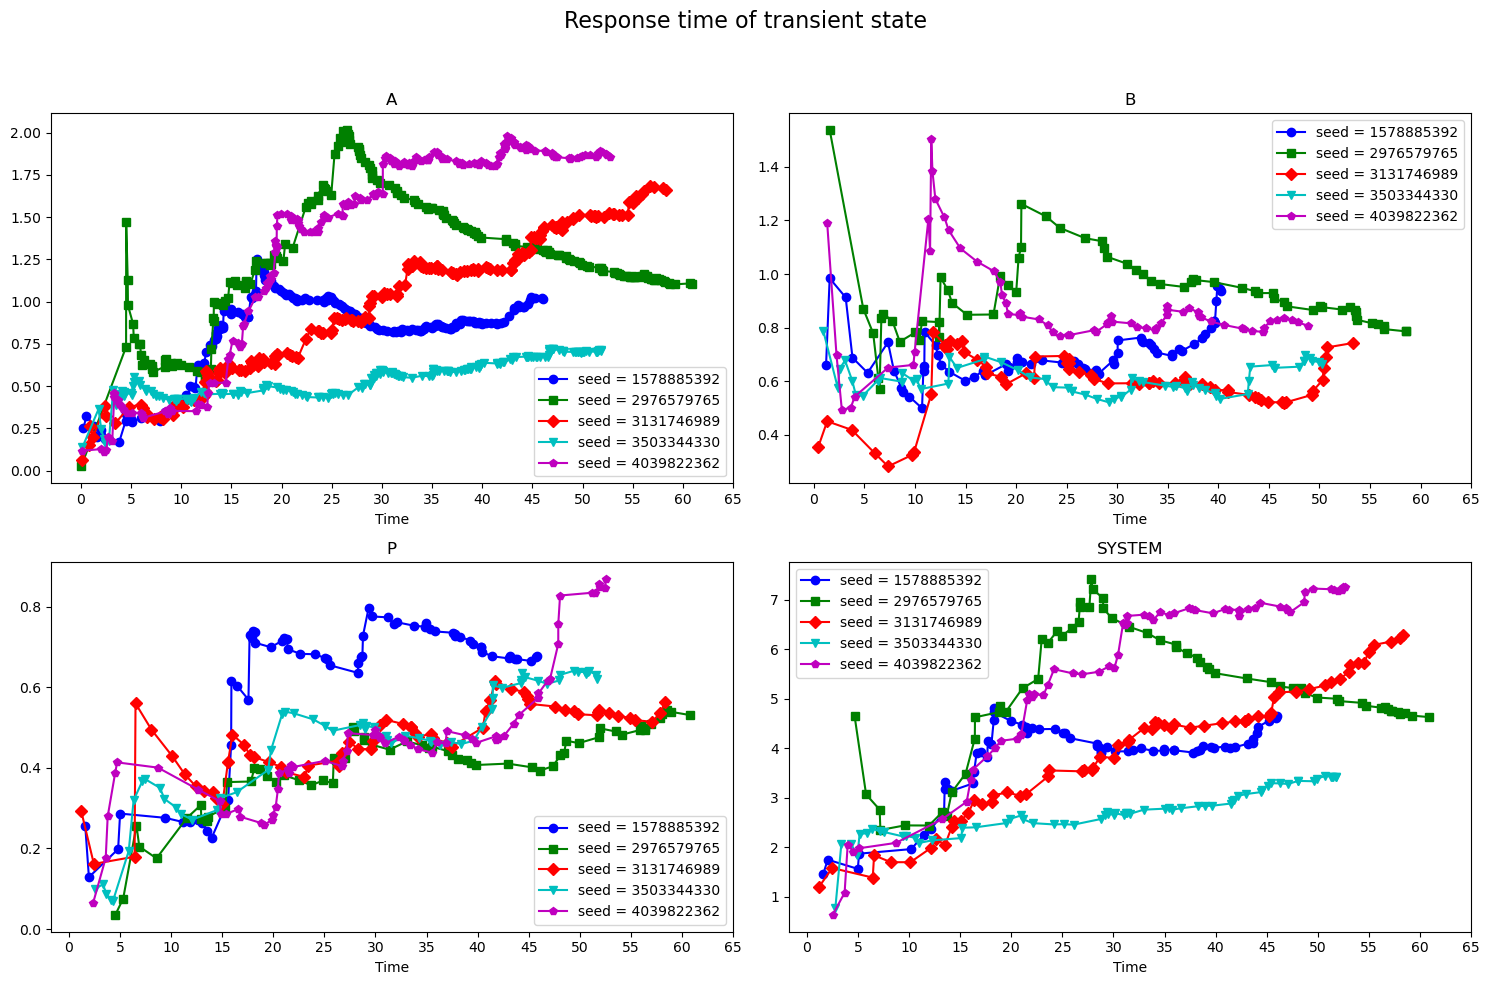

Objective = objective_4_065_TransientSimulation


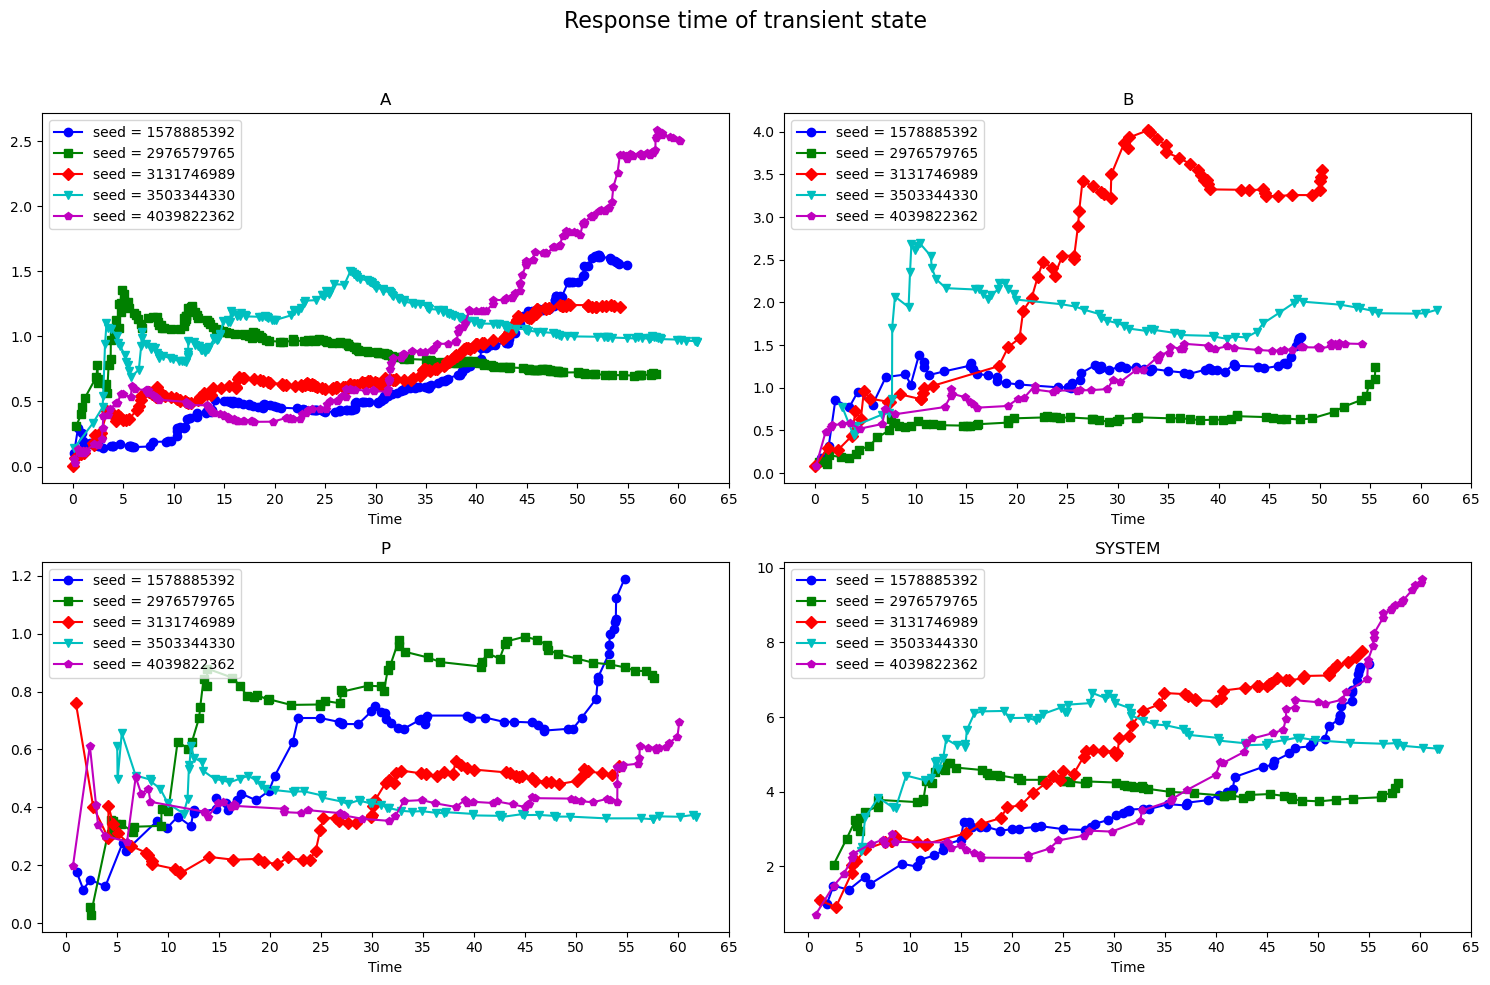

In [ ]:
# Leggere il file CSV
transient_df = pd.read_csv(os.path.join('..', '..', 'src', 'caballo', 'domestico', 'wwsimulator', 'statistics', 'Merged.csv'))

nodes = transient_df['node'].unique()
seeds = transient_df['seed'].unique()
objectives = transient_df['objective'].unique()
colors = ['b', 'g', 'r', 'c', 'm']
markers = ['o', 's', 'D', 'v', 'p']

for objective in objectives:
    print(f'Objective = {objective}')
    
    # Creazione dei subplot (2 righe, 2 colonne)
    n_rows = 2
    n_cols = (len(nodes) + 1) // 2  # Calcola il numero di colonne necessario
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 10))
    fig.suptitle('Response time of transient state', fontsize=16)
    
    # Converto axs in una lista piatta per gestire i subplot
    axs = axs.flatten()
    
    for idx, node in enumerate(nodes):
        i = 0
        ax = axs[idx]  # Seleziona il subplot corrente
        for seed in seeds:
            node_df = transient_df[
                (transient_df['node'] == node) & 
                (transient_df['seed'] == seed) & 
                (transient_df['objective'] == objective)
            ]
            ax.plot(node_df['time'], node_df['value'], linestyle='-', 
                    marker=markers[i % len(markers)], color=colors[i % len(colors)], 
                    label=f'seed = {seed}')
            i += 1
        ax.set_title(node)
        ax.set_xlabel('Time (s)')
        ax.set_xticks(range(0, 70, 5))
        ax.legend()
    
    # Rimuove gli assi non necessari se ci sono meno subplot di nodi
    for ax in axs[len(nodes):]:
        ax.remove()
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Migliora la disposizione
    plt.show()
